In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import re
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [2]:
# load the data


DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING )

In [3]:
print("Dataset size:", len(df))   #let's see the size of the data set

Dataset size: 1599999


In [4]:
df.head(5)

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
#column names
df.columns =["target", "ids", "date", "flag", "user", "text"]

In [6]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [7]:
# global names
TARGET = 'target'

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1599999 non-null  int64 
 1   ids     1599999 non-null  int64 
 2   date    1599999 non-null  object
 3   flag    1599999 non-null  object
 4   user    1599999 non-null  object
 5   text    1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [9]:
#checking if there are empty columns
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

there aren't any empty columns.

# ***Text stats***

In [10]:
texts = df['text']   #we aisolate the text column to analyze it

In [11]:
text_lens = [len(t.split()) for t in texts.values]  #we make a wordcount of every text and we get the mean.
len_mean = np.mean(text_lens)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


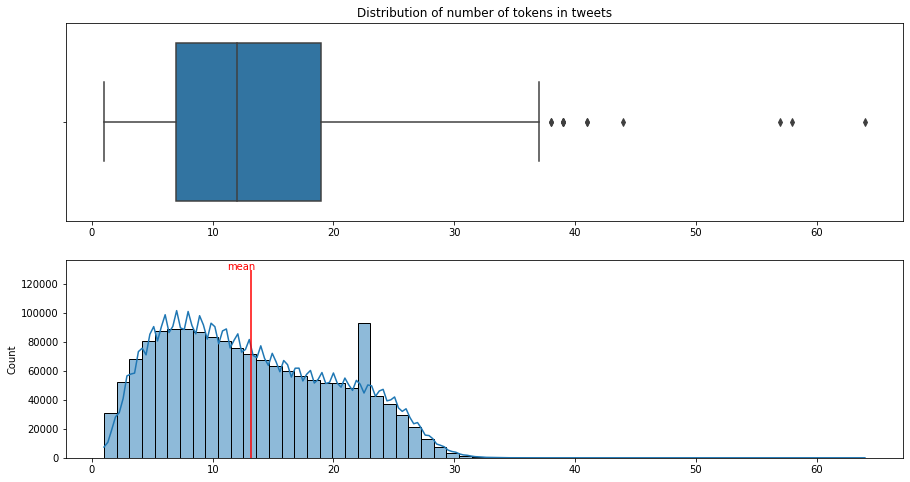

In [12]:
#we plot the wordcount and its mean

fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].set_title('Distribution of number of tokens in tweets')
sns.boxplot(text_lens, ax=axes[0])
sns.histplot(text_lens, bins=60, kde=True, ax=axes[1])
axes[1].vlines(len_mean, 0, 130000, color = 'r')
plt.annotate("mean", xy=(len_mean, 130000), xytext=(len_mean-2, 130000),
            color='r')
plt.show()

In [13]:
outliers = df['text'][np.array(text_lens) > 35] # now we try to identify and exclude the outliers
print(len(outliers))

23


In [14]:
for idx in outliers.index:
    print(idx, 'Target', df[TARGET][idx])
    print(outliers[idx])
    print('///////////////////////////////'*4, '\n')

109663 Target 0
Who Am I Lying ! ? ! I Know , You Know , We All Know , My Ass Is Still Gonna Be Up . Hehe . My Ass Can't Sleep . I Need Help . For Real ! 
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////// 

336343 Target 0
I never get 2 c u as often as I like,I never get 2 hug in my every nite  but in my heart i know u r the one i luv n can't never let u go
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////// 

374041 Target 0
I hate this , why does he have to be my step cousin  oh well , he keeps comin on to me ;) ha ha im in such a good mood , jesus , im tw ...
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////// 

461027 Target 0
Is the saddest zornes ever thanks to the magic ( :  ( :  ( :  ( :  ( :  (  :  ( :  ( :  ( :  ( :  ( :  ( :  ( :  ( :  ( :  ( :  ( :   ...
//

*As we can see these outliers seem to be fairly legitimate examples, the ones who don't are mainly because of punctuation exceses and that we can get rid off in the preprocessing step*

# Target Analysis

In [15]:
#we change the names
sentiment_dict = {0:"negative", 4:"positive"}


target_balance = df[TARGET].value_counts().rename(index=sentiment_dict)




print(target_balance)

positive    800000
negative    799999
Name: target, dtype: int64


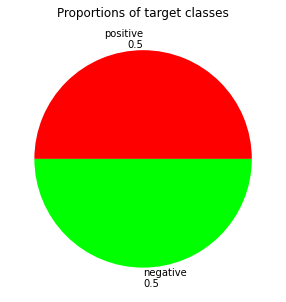

In [16]:
#now we plot the distribution

plt.figure(figsize=(5, 5))
plt.pie(target_balance, labels=[f'{idx}\n{round(target_balance[idx]/len(df), 2)}' for idx in target_balance.index], 
        colors=['r', '#00FF00'])
plt.title('Proportions of target classes')
plt.show()

Target categories are equal size, so resampling is not required.

In [17]:
# top words
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')
#let's extend the list to add "im" as we found it was not originally in the stopword list
stopwords_list.append("im")

word_counts = { 4: [],  #positive
                0: []}  #negative

pattern = re.compile('[^\w ]')
for text, target in zip(df['text'], df[TARGET]):
    text = re.sub(pattern, '', text).lower().split()
    text = [word for word in text if word not in stopwords_list]
    word_counts[target].extend(text)

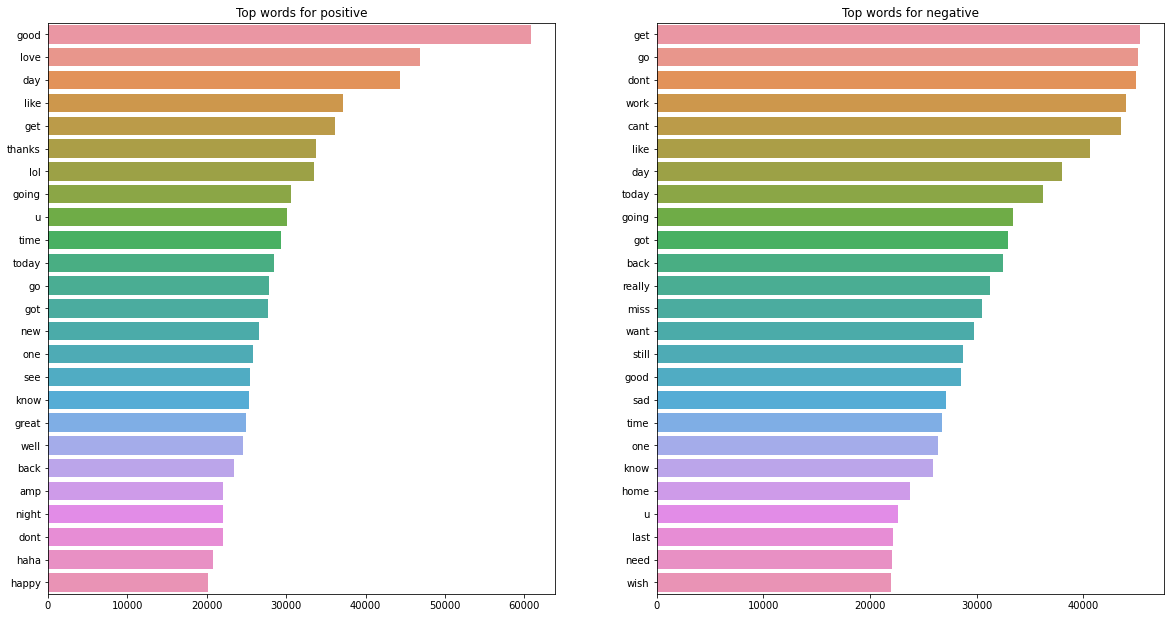

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20,10.5))
def changename(target):
    if target == 4:
        return ("positive")
    else:
        return ("negative")
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {changename(target)}')
plt.show()

In [19]:
# we can see some similar words but also we can see a clear difference given that the top positive words are words like "good, love, happy"

# Preprocessing
#

In [20]:
import nltk
from  nltk.stem import SnowballStemmer


stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
TO_CLEAN = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [21]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TO_CLEAN, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [22]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min 3s, sys: 228 ms, total: 1min 3s
Wall time: 1min 3s


# Split train and test

In [23]:
TRAIN_SIZE = 0.8
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1279999
TEST size: 320000


# Word2Vec

In [24]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 4.69 s, sys: 501 ms, total: 5.19 s
Wall time: 5.18 s


In [25]:
print(documents[0])

['second', 'get', 'back', 'haha']


In [26]:
# we use this algorithm to learn word associations from a large corpus of text.
import gensim

W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10



w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [27]:
w2v_model.build_vocab(documents)

In [28]:
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30298


In [29]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 23min 1s, sys: 5.98 s, total: 23min 7s
Wall time: 6min 31s


(263117460, 295311488)

In [30]:
w2v_model.wv.most_similar("love")

[('luv', 0.5739820003509521),
 ('loves', 0.5682447552680969),
 ('adore', 0.5552590489387512),
 ('loved', 0.5369616746902466),
 ('looove', 0.4915406405925751),
 ('amazing', 0.48298078775405884),
 ('loove', 0.46452847123146057),
 ('lovee', 0.46065524220466614),
 ('loooove', 0.45852166414260864),
 ('awesome', 0.454825758934021)]

# Tokenize Text

In [31]:
%%time
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text) 
# Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290442
CPU times: user 21 s, sys: 111 ms, total: 21.1 s
Wall time: 21.1 s


In [32]:
%%time
from keras.preprocessing.sequence import pad_sequences

# text_to_sequences transforms each text in texts to a sequence of integers. 
#So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary

SEQUENCE_LENGTH = 300

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)  
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

#pad_sequences is used to ensure that all sequences in a list have the same length

CPU times: user 28.5 s, sys: 863 ms, total: 29.4 s
Wall time: 29.4 s


# Label Encoder
#

In [33]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [34]:
%%time
df_test.target = df_test.target.apply(lambda x: decode_sentiment(x))
df_train.target = df_train.target.apply(lambda x: decode_sentiment(x))
#we change the numerical values for the target sentiment

CPU times: user 706 ms, sys: 9 ms, total: 715 ms
Wall time: 715 ms


In [35]:

POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

labels = df_train.target.unique().tolist()
labels2 = df_test.target.unique().tolist()
labels.append(NEUTRAL)
labels2.append(NEUTRAL)
labels2

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [36]:
print(labels)
print(labels2)

['POSITIVE', 'NEGATIVE', 'NEUTRAL']
['NEGATIVE', 'POSITIVE', 'NEUTRAL']


In [37]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1279999, 1)
y_test (320000, 1)


In [38]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1279999, 300)
y_train (1279999, 1)

x_test (320000, 300)
y_test (320000, 1)


In [39]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

# Embedding layer
#

In [40]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290442, 300)


In [41]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
#we build the embedding layer to map from words to vectors which you can do better analysis

# Build Model
#

In [42]:
from keras.models import Sequential

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2022-10-31 17:33:11.899402: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87132600  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,293,101
Trainable params: 160,501
Non-trainable params: 87,132,600
_________________________________________________________________


# Compile model

In [43]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# Callbacks

In [44]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),   #Reduce learning rate when a metric has stopped improving. 
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]    #Stop training when a monitored metric has stopped improving.

# Train

In [45]:
%%time

BATCH_SIZE = 1024
EPOCHS = 1             #there should be more but for the sake of time let's just do 1 epoch

history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

2022-10-31 17:33:15.138738: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1125/1125 [==============================] - 8657s 8s/step - loss: 0.5025 - accuracy: 0.7513 - val_loss: 0.4655 - val_accuracy: 0.7792
CPU times: user 6h 52min 11s, sys: 19min 49s, total: 7h 12min
Wall time: 2h 24min 18s


# Evaluate

In [46]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 524s 2s/step - loss: 0.4637 - accuracy: 0.7799

ACCURACY: 0.7798687219619751
LOSS: 0.46367740631103516
CPU times: user 24min 17s, sys: 1min 42s, total: 26min
Wall time: 8min 45s


# Predict

In [47]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [48]:
import time
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [49]:
predict("I'm having a bad day")

{'label': 'NEGATIVE',
 'score': 0.03237318992614746,
 'elapsed_time': 0.5346767902374268}

In [50]:
predict("I hate the way he looks at me")

{'label': 'NEGATIVE',
 'score': 0.048692286014556885,
 'elapsed_time': 0.20763945579528809}

In [51]:
predict("Today I will finally make it")

{'label': 'POSITIVE',
 'score': 0.8979765176773071,
 'elapsed_time': 0.20304012298583984}

In [52]:
predict("Sometimes I don't know what I'm thinking")

{'label': 'NEUTRAL',
 'score': 0.4497770667076111,
 'elapsed_time': 0.20064401626586914}

# Classification Report
#

In [53]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

scores = model.predict(x_test, verbose=1, batch_size=8000)
y_test_1d = list(df_test.target)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

print(classification_report(y_test_1d, y_pred_1d))

40/40 [==============================] - 419s 10s/step
              precision    recall  f1-score   support

    NEGATIVE       0.78      0.78      0.78    159494
    POSITIVE       0.78      0.78      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



# Accuracy Score

In [54]:
accuracy_score(y_test_1d, y_pred_1d)

0.77986875